In [4]:
from steady_state import *
from getpass import getpass
import arrow 
from dateutil import tz
from cognite.client import CogniteClient
from getpass import getpass
from datetime import datetime
import seaborn as sns
sns.set()

In [2]:
client = CogniteClient(
         api_key=getpass("Aker Data API-KEY: "), 
         project="akerbp", 
         client_name="nicholas.calen"
     )  # edit before you use this

Aker Data API-KEY: ········


/Users/nicholascalen/Documents/env/lib/python3.7/site-packages/cognite/client/_cognite_client.py:65: UserWarning: You are using version 1.4.11 of the SDK, however version 1.4.13 is available. Upgrade or set the environment variable 'COGNITE_DISABLE_PYPI_VERSION_CHECK' to suppress this warning.
  debug=debug,


In [205]:
start_date = datetime(2020, 1, 15, 16)  # specify time series to pull from cdf
end_date = datetime(2020, 1, 16, 4)
ts = client.datapoints.retrieve(
     external_id="SKAP_20LSI0030/MeasA/PRIM",
     start=start_date,
     end=end_date,
 ).to_pandas()
model = SSDetector(slope_threashold = 0.0007, 
                   state_transition_probability = 0.5,
                   number_particles = 200, n_timeless = 20)  # using the default params

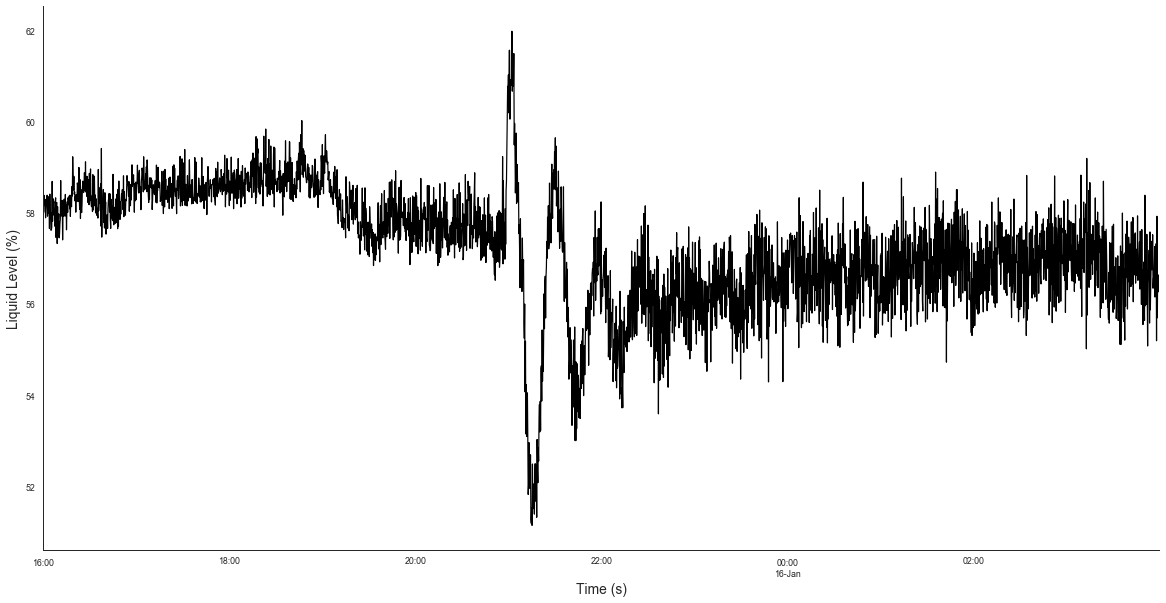

In [208]:
sns.set_style("white")
sns.set_context("paper")

ax = df.iloc[:,0].plot(figsize=(20,10), grid=False, 
                  color ='black')
ax.set_xlabel("Time (s)", fontsize = 'x-large')
ax.set_ylabel("Liquid Level (%)",fontsize = 'x-large')

sns.despine()
plt.savefig('ts')
plt.show()

In [209]:
model.train(np.squeeze(df.values, axis=1), show_results = True)

t:  1 
y_hat:  13.950583897168087 
Pt:  0.0
t: 2879 y_hat: 56.31523154770959 Pt:  0.929999999999999992656.88736055881276 Pt:  0.999999999999999856.36008626533877 Pt:  0.9999999999999998

In [210]:
df['y_hat'] = model.y_hat

In [211]:
df['y_hat'] = df.y_hat.shift(-1)

In [212]:
df['p'] = model.p_steady
df['p'] = df.p.shift(-1)

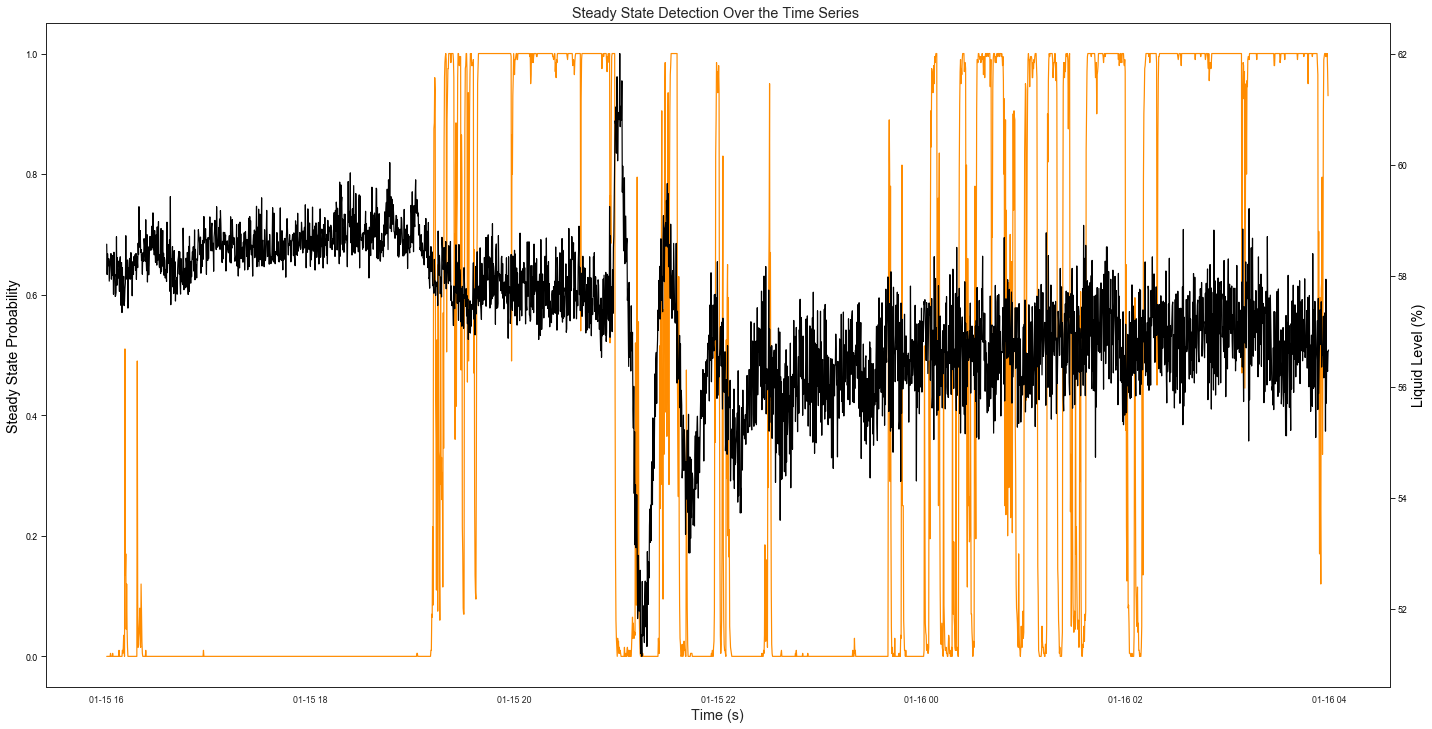

In [230]:
plt.rcParams["figure.figsize"] = (20, 10)
z = np.arange(0, len(df), 1)  # time scale
fig, ax1 = plt.subplots()
color = "tab:red"
ax1.set_xlabel("Time (s)", fontsize = 'x-large')
ax1.set_ylabel("Steady State Probability", color='black', fontsize = 'x-large')
ax1.plot(df.index, df.p[0 : len(z)], color='darkorange')  # noqa: E203
ax1.tick_params(axis="y", labelcolor='black')
ax1.grid(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel('Liquid Level (%)', color='black', fontsize = 'x-large')  # we already handled the x-label with ax1
ax2.plot(df.index, df.iloc[:,0].values, color='black')
ax2.tick_params(axis="y", labelcolor='black')
ax2.grid(False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Steady State Detection Over the Time Series ", fontsize = 'x-large')
plt.savefig('ss_result_2')
plt.show()

In [223]:
df['is_steady'] = 0 
steady_idx = df[df['p'] >0.8].index

In [224]:
df.loc[steady_idx, 'is_steady'] = 1 

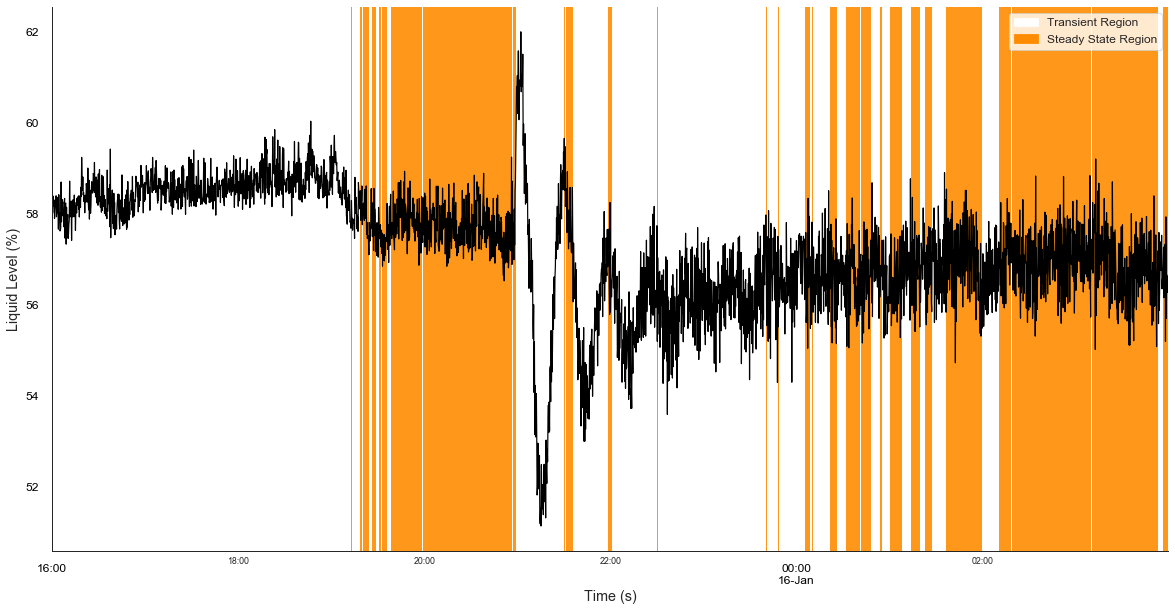

In [231]:
import seaborn as sns 
import matplotlib.patches as mpatches
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

red_patch = mpatches.Patch(color="white", label='Transient Region')
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['white', 'darkorange']
)
green_patch = mpatches.Patch(color='darkorange', label='Steady State Region')
ax = df['SKAP_20LSI0030/MeasA/PRIM'].plot(color='black')
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
               df['is_steady'].values[np.newaxis],cmap = cmap,
               alpha=0.9)
ax.tick_params(direction='out', length=10, 
               width=10, colors='black', labelsize ='large')
ax.legend(fontsize = 'large', handles=[red_patch, green_patch])
ax.set_ylabel('Liquid Level (%)',fontsize = 'x-large' )
ax.set_xlabel('Time (s)',fontsize = 'x-large')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('ss_result')